In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
import torchvision.transforms.functional as IFU
import os
from sklearn.model_selection import train_test_split
import zipfile

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import torchvision
model = torchvision.models.vgg16(weights="VGG16_Weights.DEFAULT")

n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
        nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.15),
        nn.Linear(256, 8),
)


In [5]:
load = True #### SET TO TRUE IF YOU HAVE A PRESAVED CHECKPOINT
if load:
    checkpoint = torch.load("VGG16.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['opt_state_dict'])
    results = checkpoint['results']
    done_epochs = checkpoint['epoch']
else:
    results = None
    done_epochs = 0

done_epochs

50

In [9]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
# do a test pass through of an example input size
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 8]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [14]:
# Define transformation for images
IMAGE_SIZE = (224, 224)
data_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
])

In [36]:
def get_image(filename, transform = None):
    image = Image.open(filename)
    if transform:
        image = transform(image)

    image = IFU.adjust_contrast(image, 1.7)
    return image

img_list = []
for i in range(2000):
    img_list.append(os.path.join("test_dataset", str(i+1)+".jpg"))


img = get_image(img_list[646], data_transform)

torch.Size([3, 224, 224])

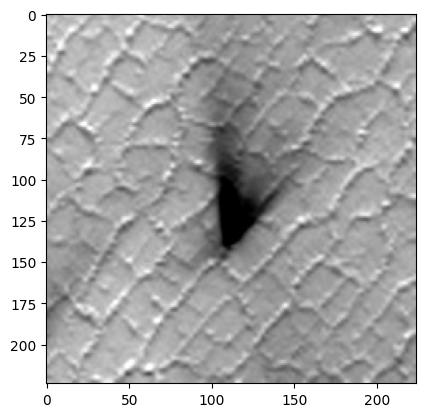

In [37]:
plt.imshow(img.permute(1,2,0))
img.shape

In [38]:
model.eval()
with torch.inference_mode():
    pred = model(img.unsqueeze(0).to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1).item()}\n")

Output logits:
tensor([[-14.1961, -15.1621,  14.1214,  -5.9610, -12.1800,  -8.5621,  -5.5947,
           0.5472]], device='cuda:0')

Output prediction probabilities:
tensor([[5.0337e-13, 1.9158e-13, 1.0000e+00, 1.8981e-09, 3.7796e-12, 1.4082e-10,
         2.7379e-09, 1.2729e-06]], device='cuda:0')

Output prediction label:
2



In [24]:
predictions = []
for i in range(2000):
    image_path = img_list[i]
    img = get_image(image_path, data_transform)
    model.eval()
    with torch.inference_mode():
        pred = model(img.unsqueeze(1).to(device))

    label = torch.argmax(torch.softmax(pred, dim=1), dim=1)
    predictions.append(label.item())

In [25]:
label_to_int_map = {
    'bright dune': 0,
    'dark dune': 1,
    'spider': 2,
    'impact ejecta': 3,
    'slope streak': 4,
    'swiss cheese': 5,
    'crater': 6,
    'other': 7
}

int_to_label_map = {v:k for k, v in label_to_int_map.items()}

In [39]:
img_names_series = pd.Series([str(i) + ".jpg" for i in range(1, 2001)])
pred_labels_series = pd.Series(predictions)
pred_label_names = pred_labels_series.replace(int_to_label_map)

In [42]:
out_df = pd.concat([img_names_series, pred_label_names, pred_labels_series], axis=1)

,0,1,2
0,1.jpg,other,7
1,2.jpg,other,7
2,3.jpg,other,7
3,4.jpg,other,7
4,5.jpg,other,7
...,...,...,...
1995,1996.jpg,other,7
1996,1997.jpg,other,7
1997,1998.jpg,other,7
1998,1999.jpg,other,7
